#6. GO/STOP! - Object Detection 시스템 만들기

이번 프로젝트에는 object detection 모델을 통해 주변에 다른 차나 

사람이 가까이 있는지 확인한 후 멈출 수 있는 자율주행 시스템을 만들어 보겠습니다.

하지만 자율주행 시스템은 아직 완벽한 단계는 아니므로 판단이 어려운 상황에는 

직접 멈추도록 설계하는 구조를 가진 미니 자율주행 보조장치를 만들어보겠습니다.

목차

- 구글 드라이브 및 라이브러리 임포트

- 데이터셋 다운로드 및 정보 확인

- 바운딩 박스 표시

- 데이터 전처리 함수 구현

- 모델 작성

- 모델 학습

- 모델 결과 시각화

- 자율주행 시스템 만들기

- 마무리
---

##구글 드라이브 및 라이브러리 임포트

구글 드라이브에 데이터 파일을 올리고 사용할것이므로,

드라이브 임포트 및 프로젝트를 진행하는데 필요한 라이브러리를 임포트 해줍니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

DATA_PATH = '/content/drive/MyDrive/data/'

----

## 데이터셋 다운로드 및 정보 확인

필요한 데이터셋을 tfds.load를 통하여 다운받고

다운 받은 파일을 정보를 확인해봅니다.

- 이미지 확인

- feature 확인

- 클래스 수 확인

- 클래스 이름 확인

- 이미지 시각화

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

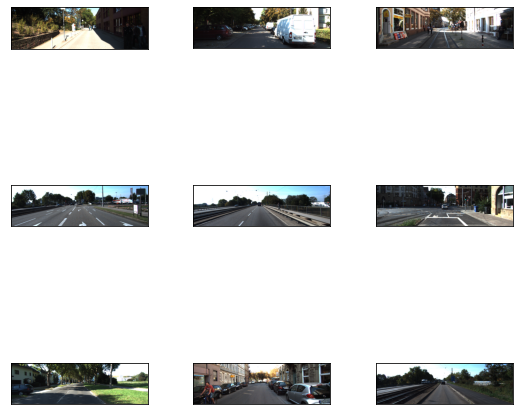

In [ ]:
_ = tfds.show_examples(ds_train, ds_info)

In [ ]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/file_name': Text(shape=(), dtype=tf.string),
    'objects': Sequence({
        'alpha': tf.float32,
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'dimensions': Tensor(shape=(3,), dtype=tf.float32),
        'location': Tensor(shape=(3,), dtype=tf.float32),
        'occluded': ClassLabel(shape=(), dtype=tf.int64, num_classes=4),
        'rotation_y': tf.float32,
        'truncated': tf.float32,
        'type': ClassLabel(shape=(), dtype=tf.int64, num_classes=8),
    }),
})


In [ ]:
NUM_CLASSES = ds_info.features["objects"]["type"].num_classes
NUM_CLASSES  # 8

8

In [ ]:
TYPE_NAMES = ds_info.features["objects"]["type"].names
TYPE_NAMES

['Car',
 'Van',
 'Truck',
 'Pedestrian',
 'Person_sitting',
 'Cyclist',
 'Tram',
 'Misc']

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.12], dtype=float32)>, 'bbox': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.29058668, 0.4578905 , 0.52949333, 0.6107971 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[1.55, 1.66, 3.37]], dtype=float32)>, 'location': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 1.02,  1.64, 13.62]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>, 'rotation_y': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.19], dtype=float32)>, 'truncated': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, 'type': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>}


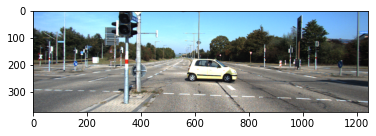

(1242, 375)


In [ ]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()
print(img.size)

----

##바운딩 박스 표시

위에서 시각화 시킨 이미지에 자동차가 있습니다.

자동차에 바운딩 박스를 표시해보겠습니다.

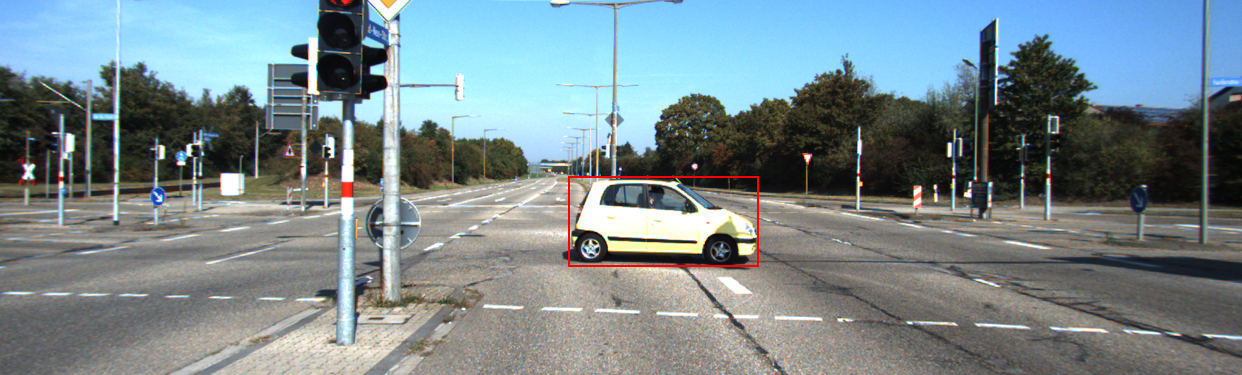

In [ ]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())

---

## 데이터 전처리 함수 구현

이번 프로젝트에서는 RetinaNet을 사용해보겠습니다.

RetinaNet은 Detection 속도를 1-stage detector 모델 만큼내고 정확도는 2-stage detector 만큼을 정확도를 가지게 만든 모델입니다.

즉, 이를 구현하기 위해서 RetinaNet에서는 focal loss와 FPN(Feature Pyramid Network) 를 적용한 네트워크를 사용합니다.

focal loss란?

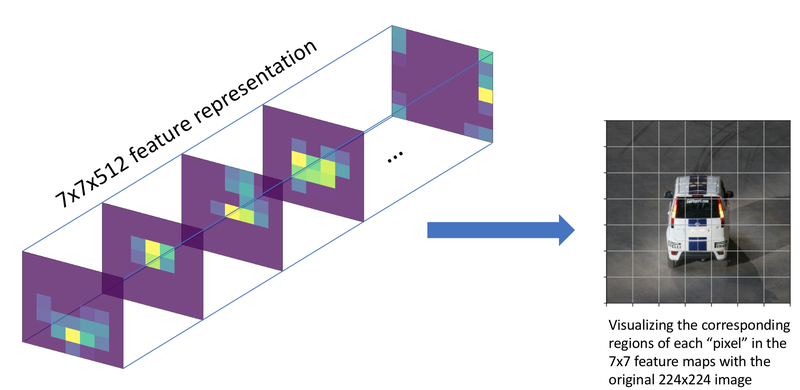

Focal loss는 기존의 1-stage detection 모델들(YOLO, SSD)이 물체 전경과 배경을 담고 있는 

모든 그리드(grid)에 대해 한 번에 학습됨으로 인해서 생기는 클래스 간의 불균형을 해결하고자 도입되었습니다. 

여기서 그리드(grid)와 픽셀(pixel)이 혼란스러울 수 있겠는데, 위 그림 왼쪽 7x7 feature level에서는 한 픽셀이고, 

오른쪽의 image level(자동차 사진)에서 보이는 그리드는 각 픽셀의 receptive field입니다.

그림에서 보이는 것처럼 우리가 사용하는 이미지는 물체보다는 많은 배경을 학습하게 됩니다.

그 다음으로는 FPN에 대해서 알아 보겠습니다.

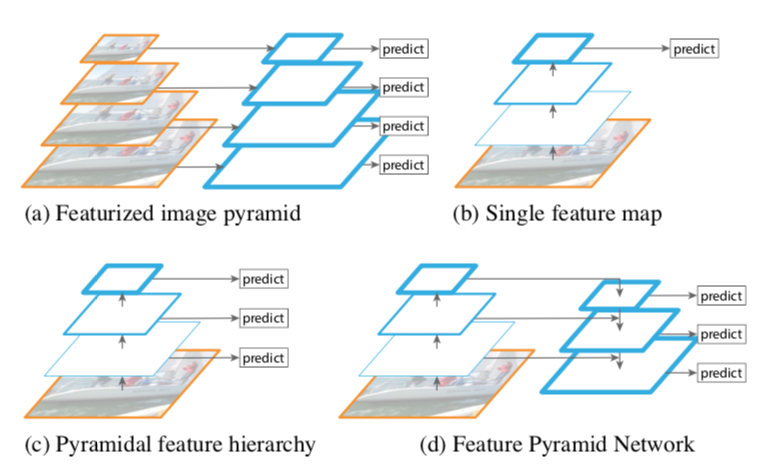

FPN은 특성을 피라미드처럼 쌓아서 사용하는 방식입니다. 

CNN 백본 네트워크에서는 다양한 레이어의 결과값을 특성 맵(feature map)으로 사용할 수 있습니다.

FPN은 백본의 여러 레이어를 한꺼번에 쓰겠다라는데에 의의가 있습니다.

이와 같은 모델을 쓰기 위해 3가지 함수를 만들어 보겠습니다.



```
def swap_xy(boxes)
```
함수는 모든 이미지를 수평으로 바꿀 것이기 때문에 좌표축을 변환 시켜주는 함수입니다.



```
def random_flip_horizontal(image, boxes)
```
이미지를 무조건 수평으로 바꿔주는 함수입니다.



```
resize_and_pad_image(image, training=True)
```
입력할 이미지의 크기를 바꾸어주는 함수입니다.



```
def preprocess_data(sample)
```
준비된 함수들을 모두 연결시켜주는 함수입니다.





In [ ]:
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

---

###인코딩 구현

Anchor Box라는 클래스를 만들겠습니다.

이때 Anchor Box란?

One stage detector에서는 Anchor Box라는 정해져 있는 위치, 크기, 비율 중에 하나로 물체의 위치가 결정됩니다. 

그래서 기본적으로 Anchor Box를 생성해줘야 합니다.

Anchor Box로 생성되는 것은 물체 위치 후보라고 생각하면 됩니다. 

물체 위치를 주관식이 아닌 객관식으로 풀게 하는 겁니다.

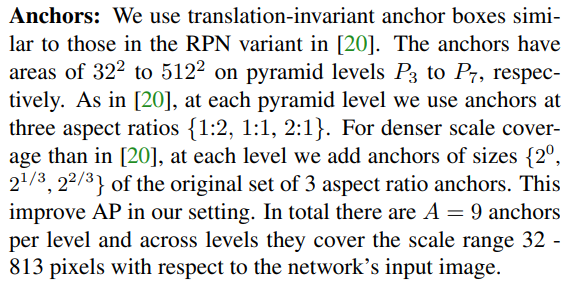

위에 논문과 최대한 비슷하게 Anchor Box를 생성해줍니다.



```
def _compute_dims(self)
```
Anchor Box를 생성했으니 입력할 데이터를 Anchor Box에 맞게 변형주는 함수입니다.


In [ ]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

---

###LabelEncoder

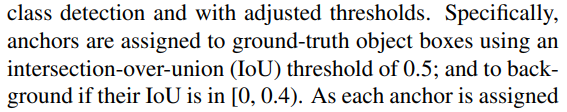

In [ ]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

In [ ]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

---

##모델 작성

###Feature Pyramid

앞서 설명했듯이 RetinaNet에서는 FPN(Feature Pyramid Network)를 사용합니다.

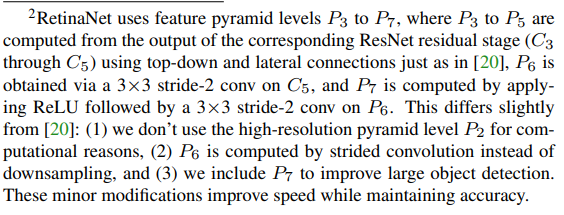


In [ ]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

---

###build_head 함수 구현

class와 box가 모두 맞을 수도, class와 box 중 하나만 맞을 수도, 

둘 다 틀릴 수도 있겠죠? 

class를 예측하는 head와 box를 예측하는 head가 별도로 존재한다는 것이 중요합니다.

그래서 각각의 head를 만들어 줍니다. 

head부분은 유사한 형태로 만들 수 있으니 build_head라는 함수를 하나만 만들고 두 번 호출하면 될 것 같네요.

In [ ]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

In [ ]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

----

###RetinaNet 완성

Backbone + FPN + classification용 head + box용 head 입니다.

In [ ]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

---

### RetinaNet loss 구현

RetinaNet에서는 Focal Loss를 사용하는데요. 

Box Regression에는 사용하지 않고 Classification Loss를 계산하는데만 사용됩니다. 

Box Regression에는 Smooth L1 Loss를 사용했습니다.

이와 같은 구조를 표현하기 위한 함수를 만들어주겠습니다.

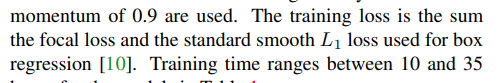

In [ ]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

---

##모델 학습

클래스 수와 배치사이즈를 미리 정의해줍니다.

또한 backbone으로는 미리 학습이 되어있는 ResNet50을 사용하도록 하겠습니다.

In [ ]:
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

94781440/94765736 [==============================] - 0s 0us/step


---

###모델 학습 환경 설정

논문에서는 8개의 GPU를 사용했기 때문에 우리 환경과는 맞지 않습니다. 

그래서 Learning Rate를 적절히 바꿔주고 저는 여기에 accuracy를 추가해주겠습니다.

In [ ]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss = loss_fn, optimizer = optimizer, metrics = ['accuracy'])

---

###데이터 전처리 파이프라인 생성

In [ ]:
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

---

### 모델 학습 시작

실습 코드에서는 체크포인트를 만들어 모델을 가중치를 직접 저장하였지만,

체크포인트 부분에서 오류가 계속 발생하여 체크포인트는 따로 사용하지 않았습니다.

In [ ]:
epochs = 20
    
hist = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = epochs,
)

Epoch 1/20
3173/3173 [==============================] - 1002s 308ms/step - loss: 2.1845 - accuracy: 0.2757 - val_loss: 1.5922 - val_accuracy: 0.2745
Epoch 2/20
3173/3173 [==============================] - 1004s 315ms/step - loss: 0.9768 - accuracy: 0.2382 - val_loss: 1.2223 - val_accuracy: 0.1856
Epoch 3/20
3173/3173 [==============================] - 986s 310ms/step - loss: 0.7250 - accuracy: 0.2260 - val_loss: 1.1155 - val_accuracy: 0.2549
Epoch 4/20
3173/3173 [==============================] - 983s 309ms/step - loss: 0.5734 - accuracy: 0.2371 - val_loss: 1.0190 - val_accuracy: 0.2214
Epoch 5/20
3173/3173 [==============================] - 979s 307ms/step - loss: 0.4834 - accuracy: 0.2274 - val_loss: 0.9698 - val_accuracy: 0.2422
Epoch 6/20
3173/3173 [==============================] - 980s 307ms/step - loss: 0.4049 - accuracy: 0.2149 - val_loss: 0.9826 - val_accuracy: 0.2341
Epoch 7/20
3173/3173 [==============================] - 982s 308ms/step - loss: 0.3537 - accuracy: 0.2192 - va

---

##모델 결과 시각화

실습에서는 accuracy를 구현하지 않았지만, 여기서는 구현해보아

시각화를 한번 진행해보았습니다.

딱히 유의미한 결과를 도출해낸거 같진 않습니다.

In [ ]:
def draw_history(hist):
    plt.subplots(figsize=(12,4))

    # Model Loss, Validation Loss 시각화
    plt.subplot(121)
    plt.plot(hist.history['loss'], 'r')
    plt.plot(hist.history['val_loss'], 'b')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')

    # Model Accuracy, Validation Accuracy 시각화
    plt.subplot(122)
    plt.plot(hist.history['accuracy'], 'r')
    plt.plot(hist.history['val_accuracy'], 'b')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')

    plt.tight_layout()
    plt.show()

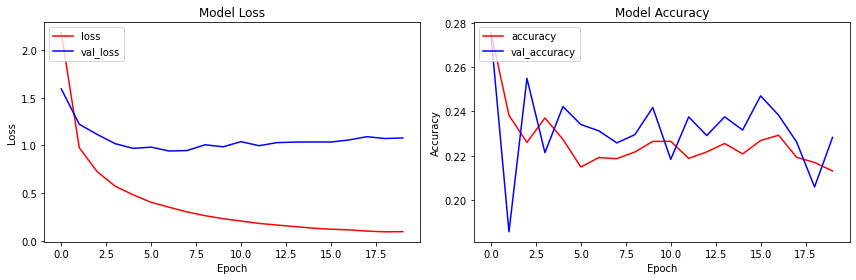

In [ ]:
draw_history(hist)

---

###모델 결과 확인 및 모델 평가하기

NMS(Non-Max Suppression)은 직접 구현하지 않고 주어진 

tf.image.combined_non_max_suppression를 사용했습니다.

In [ ]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

---

###모델 조립

In [ ]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

---

###모델 결과 시각화 함수

테스트 사진에 대해서 바운딩 박스를 보여주면서 결과를 확인할 수 있는 시각화

함수를 만들어 줍니다.

In [ ]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

---

###학습 결과 전처리 함수

학습을 위한 전처리와 결과 추론을 위한 전처리가 다릅니다.

따라서 추론을 위한 전처리 함수도 작성이 되어야합니다.

In [ ]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

---

###학습 결과 시각화

지금까지 준비한 함수들을 사용하여 학습된 결과를 시각화하겠습니다.

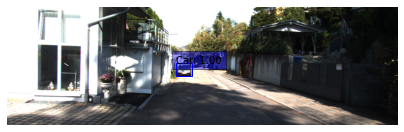

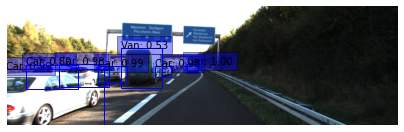

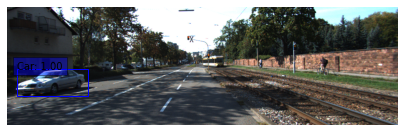

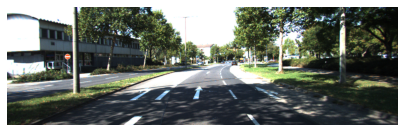

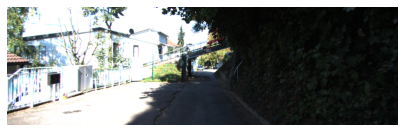

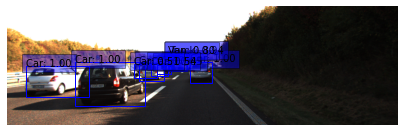

In [ ]:
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(6):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

---

##자율주행 시스템 만들기

위에서 만든 모델을 통해 아래의 조건을 만족하는 함수를 만들어 주세요.

입력으로 이미지 경로를 받습니다.

정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.

조건은 다음과 같습니다.

- 사람이 한 명 이상 있는 경우

- 차량의 크기(width or height)가 300px이상인 경우

###필요한 라이브러리 설치

In [ ]:
!pip install keras_retinanet

---

###이미지 추출 함수

이미지 추출 함수를 만들고 images안에 이미지 경로를 하나하나 따로 저장해줍니다.

In [ ]:
def get_images(path, type):
    import glob
    if not os.path.exists(path):
        print('path 경로 오류')
        return None
    else:
        images = glob.glob(path + "/*."+type)
    return images

In [ ]:
img_path = "/content/drive/MyDrive/pic/pict"
images = get_images(img_path, 'png')
print(images)

from keras_retinanet.utils.image import read_image_bgr
import cv2

['/content/drive/MyDrive/pic/pict/go_1.png', '/content/drive/MyDrive/pic/pict/go_5.png', '/content/drive/MyDrive/pic/pict/stop_3.png', '/content/drive/MyDrive/pic/pict/go_4.png', '/content/drive/MyDrive/pic/pict/stop_4.png', '/content/drive/MyDrive/pic/pict/go_3.png', '/content/drive/MyDrive/pic/pict/go_2.png', '/content/drive/MyDrive/pic/pict/stop_2.png', '/content/drive/MyDrive/pic/pict/stop_1.png', '/content/drive/MyDrive/pic/pict/stop_5.png']


---

###이미지 시각화

위에서 불러온 이미지를 토대로 클래스가 Pedestrian이면 stop을 출력

픽셀 크기가 300을 넘어도 stop을 출력할 수 있는 함수를 만들어 주고 

이미지를 시각화하여 어떤 값을 리턴해주는지 확인해봅니다.

In [ ]:
def self_drive_assist(img_path, size_limit=300):
    image = read_image_bgr(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = tf.cast(image, dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
                    int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
        ]

    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )
    count=0

    for i in class_names: 
        if "Pedestrian" in class_names:
            return "Stop"

    box = detections.nmsed_boxes[0][:num_detections] / ratio
    
    for i in box:
        x1, y1, x2, y2 = i
        w, h = x2 - x1, y2 - y1
        if w.numpy() >= 300 or h.numpy() >= 300:
            return "Stop"    
    return "Go"

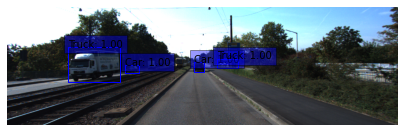

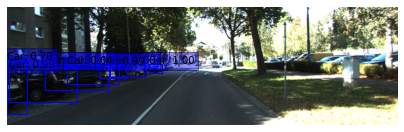

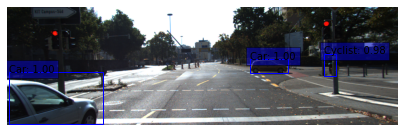

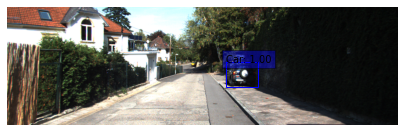

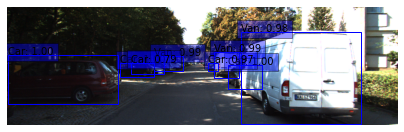

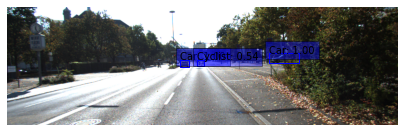

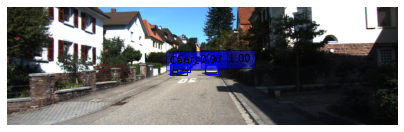

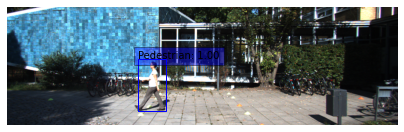

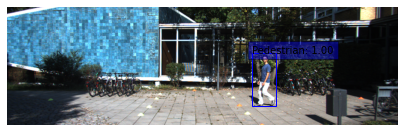

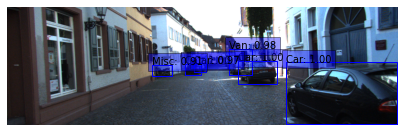

['Go', 'Go', 'Go', 'Go', 'Stop', 'Go', 'Go', 'Stop', 'Stop', 'Stop']


In [ ]:
# Stop 이미지 5장 그리고 Go 이미지 5장을 확인 해봅니다.
result = []
for i in images:
    result.append(self_drive_assist(i))

print(result)

---

###자율주행 시스템 평가 점수출력

이미지에 10장으로 자율주행 시스템을 평가해보겠습니다.

1장당 10점으로 잡고 맞으면 10을 더해주고 틀리면 빼주는 방식으로 해보겠습니다.

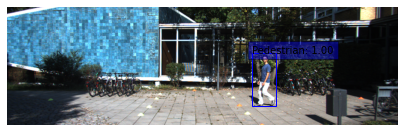

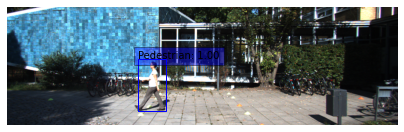

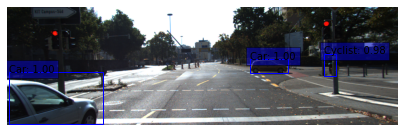

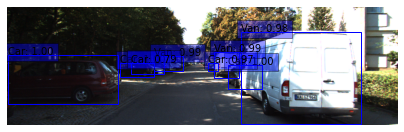

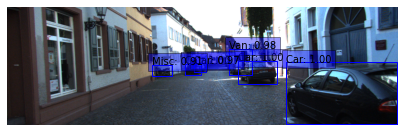

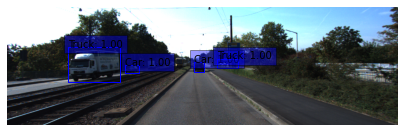

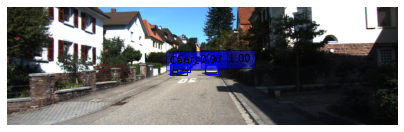

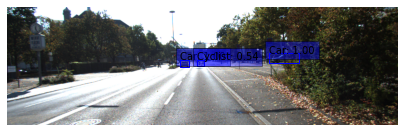

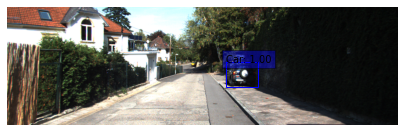

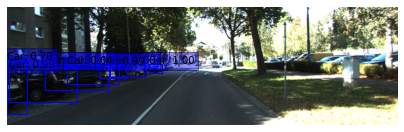

90점입니다.


In [ ]:
import os

def test_system():
    work_dir = "/content/drive/MyDrive/pic/pict"
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = self_drive_assist(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system()

---

##마무리

어려웠던 점

- 체크포인트에 모델 가중치가 저장되지 않음(경로 문제일 가능성이 높음)

- 학습 시간이 너무 오래걸림

- 여러개의 모델을 합치는 점과 결과 확인을 위한 전처리 부분

###최종 결론

RetinaNet이라는 모델을 처음 접하면서 Detection에 대한 생각이 바뀌는 순간이었다.

Detection이라고 하면 YOLO 또는 Detectron이라는 모델만 알고있었다.

그것이 1-stage detection인지 2-stage detection인지는 생각하지 않고 있었다.

하지만 이번 프로젝트를 진행하면서 Detection에는 1-stage detection와 2-stage detection가 존재하고

1-stage detection 속도를 내면서 2-stage detection을 성능을 이끌어내는 모델이 존재하는것도 알게되었다.

이 모델이 RetinaNet이다.

RetinaNet은 Focal Loss와 FPN이라는 기능을 접목시켜 2-stage detection 성능을 이끌어낸다고 알고있다.

FRN이라는 개념이 상당히 흥미롭다.
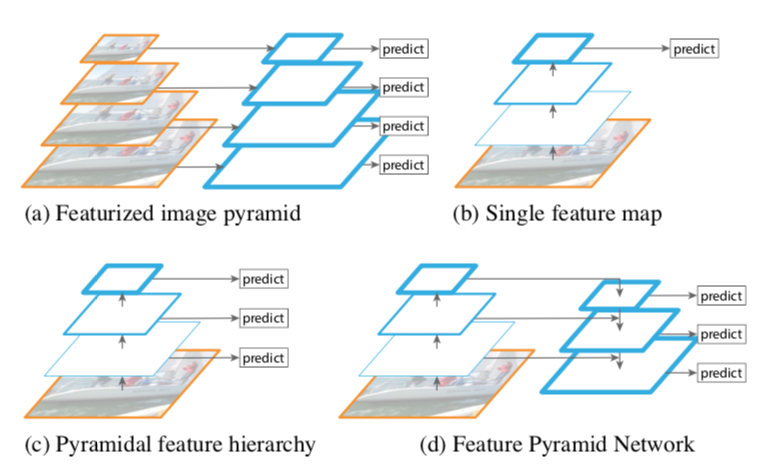

1. 이미지를 줄이면서 각 결과값을 추출

2. 특성을 피라미드처럼 쌓아서 사용한다.

3. 즉, 이미지를 넓게 보는 것과 좁게 보는 것을 같이 사용하겠다는 목적

이 점이 상당히 흥미로웠고 그 만큼 구현 부분이 어려워서 고생하였다.

기회가 되면 더 다양한 모델을 사용해보고 싶다.
